#### The present simulation aims at evaluating the properties of two estimators for the population benefit of an individual treatment rule $ r $

$$  \widehat{ARE}(r)= n^{-1} \sum_{i=1}^{n} \{ r(X_i) -\hat{e}(X_i) \} \hat{\tau}(x)  $$

$$  \widehat{ASRE}(r)= n^{-1} \sum_{i=1}^{n} \hat{p}(X_i) \{ r(X_i) -\hat{e}(X_i) \} \hat{\tau}(x)  $$


- In the case of implementation of $ r $ at random with probability $ \alpha $
$$ \hat{p}(X_i)=\alpha $$
- In the case of implementation of $ r $ with cognitive bias $ \alpha \in [0;1[ $
$$ \hat{p}(X_i)=(1-|r (X_i) - \hat{e} (X_i) |)^{ \frac{1}{2}\log{ \frac{\alpha + 1}{1 - \alpha} } } $$

- In the case of implementation of $ r $ only when  $ (1 - \alpha) $ confidence interval for the individualized Hazard Ratio does not cross 1
$$ \hat{p}(X_i)=\mathbb{1} { \{ i_{hr}(X_i) - q_ { 1 - \alpha /2 } se_{i_{hr(X_i)}  } -1 \}  \{ i_{hr}(X_i) + q_ { 1 - \alpha /2 } se_{i_{hr(X_i)}  } -1 \} } > 0 $$

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
from tableone import TableOne, load_dataset
import random
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
pd.options.mode.chained_assignment = None  # default='warn'

#### Setting data generation parameters

In [2]:
n = 1000  # size of each sample
sims = 500  # number of repeated samples
np.random.seed(1015033030)

#### Generating data

In [3]:
ids = []  # Generating simulation IDs
for i in range(sims):
    ids.extend([i + 1] * n)

df = pd.DataFrame()
df['sim_id'] = ids

In [4]:
# Creating confounders
df['age'] = np.round(np.random.normal(65, 10, size=n * sims), 0)  
df['crcl_log'] = np.random.normal(np.log(110), 0.18, size=n * sims) - 0.005 * df['age']
df['crcl'] = np.exp(df['crcl_log'])
df['diabetes'] = np.random.binomial(n=1, p=st.logistic.cdf(-6.73 + 0.03 * df['crcl_log'] + 0.02 * df['age'] +
                                                        0.0009 * df['age'] ** 2), size=n * sims)
df['insulin'] = np.where(df['diabetes']==1,
                    np.random.binomial(n=1, p=st.logistic.cdf(-4.16 + 0.04 * df['crcl_log'] - 0.02 * df['age'] +
                                                        0.0009 * df['age'] ** 2), size=n * sims),
                         0)
df['lvef'] = np.random.beta(11, 7, size=n * sims)*100 - 0.06 * df['age']
df['smoking'] = np.random.binomial(n=1, p=.21, size=n * sims)
df['pvd'] = np.random.binomial(n=1, p=st.logistic.cdf(-5.62 + 0.03 * df['smoking'] - 0.02 * df['age'] +
                                                        0.0009 * df['age'] ** 2), size=n * sims)
df['copd'] = np.random.binomial(n=1, p=st.logistic.cdf(-2.71 + 0.03 * df['smoking'] + 0.01 * df['pvd']), size=n * sims)
                                
df['tvd_lmcad'] = st.betabinom.rvs(2, .4, .7, loc=0, size=n * sims, random_state=None) #nb 0=3vd only, 1=lmcad only, 2=both

# One-hot encoding
df['tvd'] = np.where(df['tvd_lmcad']==0, 1, 0)
df['lmcad'] = np.where(df['tvd_lmcad']==1, 1, 0)
df['both'] = np.where(df['tvd_lmcad']==2, 1, 0)

#### Define and run a function that generates anatomical SYNTAX scores

In [5]:
def sim_anat_syntax(tvd_lmcad):
    """simulate anatomic syntax scores from coronary disease type."""
    from zepid.sensitivity_analysis import trapezoidal
    
    dummy_mat=np.stack([tvd_lmcad==0, tvd_lmcad==1, tvd_lmcad==2], axis=1)
    
    tvd=trapezoidal(3,10,10,50, len(tvd_lmcad))
    lmcad=trapezoidal(4,20,20,50, len(tvd_lmcad))
    both=trapezoidal(7,10,30,60, len(tvd_lmcad))
    
    return(dummy_mat[:,0]*tvd + dummy_mat[:,1]*lmcad + dummy_mat[:,2]*both)

df['syntax']= np.round(sim_anat_syntax(df['tvd_lmcad']))

#### Plot the generated anatomical SYNTAX scores

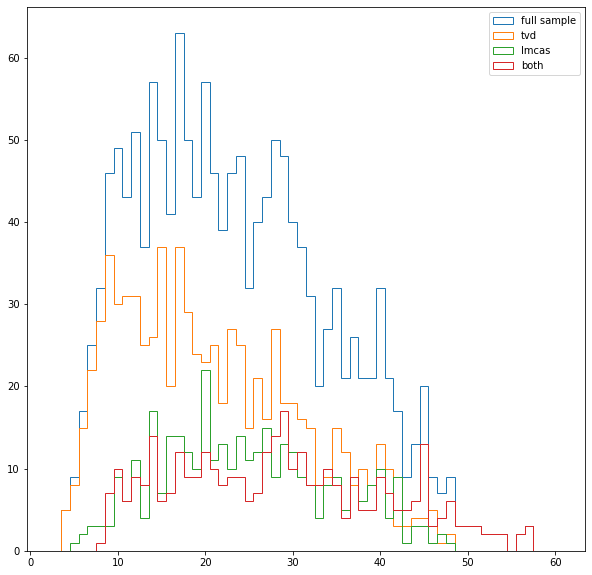

In [6]:
ind_tvd=df['tvd_lmcad']==0
ind_lmcad=df['tvd_lmcad']==1
ind_both=df['tvd_lmcad']==2

plt.figure(figsize=(10,10))
plt.hist(df['syntax'], histtype="step", bins=np.linspace(2.5,60.5, 59), label="full sample");
plt.hist(df['syntax'][ind_tvd], histtype="step", bins=np.linspace(2.5,60.5, 59), label="tvd");
plt.hist(df['syntax'][ind_lmcad], histtype="step", bins=np.linspace(2.5,60.5, 59), label="lmcas");
plt.hist(df['syntax'][ind_both], histtype="step", bins=np.linspace(2.5,60.5, 59), label="both");
plt.legend();

#### Plot LVEFs

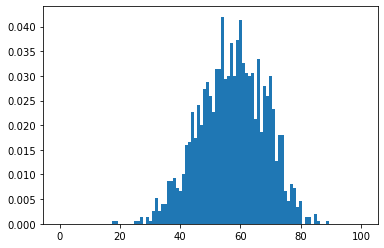

In [7]:
plt.hist(df.lvef, density=True, bins=np.linspace(-.5, 100.5, 102));

In [8]:
categorical = ['diabetes','insulin','smoking','pvd','copd','tvd_lmcad']
columns = ['age', 'crcl_log', 'diabetes', 'insulin', 'lvef', 'smoking', 'pvd','copd', 'tvd_lmcad']
#mytable = TableOne(df.iloc[0:n,:], columns = columns, categorical=categorical)
#print(mytable.tabulate(tablefmt="github"))

#### Treatment allocation mechanism (True Propensity Score)

In [9]:
df['cabg_pr'] = st.logistic.cdf(-2.971
                               + 0.049 * (df['age'] - 30)
                               - 0.001 * (df['age'] - 30)**2
                               + 0.212 * df['crcl_log']
                               + 0.973 * np.where(df['crcl_log'] > np.log(100), 1, 0)
                               - 0.386 * df['copd']
                               # Treatment-assignment based on disease type
                               + 1.973 * df['lmcad']
                               + 2.973 * df['both']
                               )
df['cabg'] = np.random.binomial(n=1, p=df['cabg_pr'], size=n*sims)

#### Potential outcomes

#### Define Syntax 2020 Model for predicting risk of all-cause death at 10 years
 as defined in Takahashi et al. Lancet 2020. Table 2

In [10]:
def syntax2020(age, crcl, lvef, copd, pvd, diabetes, insulin, smoking, tvd, lmcad, syntax, cabg):
    return 1-np.exp(-0.243 *np.exp(0.99 * (0.72*age/10 - 0.07 * np.where(crcl<90, crcl ,90)/10 -0.31 * np.where(lvef<50, lvef, 50)/10 + 0.48 * copd + 0.73 * pvd + 0.20 * diabetes 
                    + 0.46 * insulin + 0.66 * smoking)
                    - 0.4 * cabg * tvd - 0.08 * cabg * lmcad - 0.1 * (1 - cabg) * lmcad + .16 * (1-cabg) * (syntax - 29)/10 -2.80))

Reproduce first example from Takahashi et al. Lancet 2020
- Figure 1, Case 1, PCI scenario

In [11]:
syntax2020(age=74, crcl=38.6, lvef=40, copd=0, pvd=0, diabetes=0, insulin=0, smoking=1, tvd=0, lmcad=1, syntax=11, cabg=0)

0.5699878103841629

- Figure 1, Case 1, CABG scenario

In [12]:
syntax2020(age=74, crcl=38.6, lvef=40, copd=0, pvd=0, diabetes=0, insulin=0, smoking=1, tvd=0, lmcad=1, syntax=11, cabg=1)

0.6828410898159403

In [13]:
df['prY1'] = df.apply(lambda row : syntax2020(age=row['age'], crcl=np.exp(row['crcl_log']), lvef=row['lvef'],
                                copd=row['copd'], pvd=row['pvd'], diabetes=row['diabetes'],
                                 insulin=row['insulin'], smoking=row['smoking'], tvd=row['tvd_lmcad']==0,
                                 lmcad=row['tvd_lmcad']==1, syntax=row['syntax'],
                                 cabg=1), axis = 1)

df['Y1'] = np.random.binomial(n=1, p=df['prY1'], size=n*sims)

df['prY0'] = df.apply(lambda row : syntax2020(age=row['age'], crcl=np.exp(row['crcl_log']), lvef=row['lvef'],
                                copd=row['copd'], pvd=row['pvd'], diabetes=row['diabetes'],
                                 insulin=row['insulin'], smoking=row['smoking'], tvd=row['tvd_lmcad']==0,
                                 lmcad=row['tvd_lmcad']==1, syntax=row['syntax'],
                                 cabg=0), axis = 1)

df['Y0'] = np.random.binomial(n=1, p=df['prY0'], size=n*sims)

df['Y'] = np.where(df['cabg'] == 1, df['Y1'], df['Y0'])  # causal consistency

df['true_cate'] = df['prY1'] - df['prY0']

df['pred_cate'] = df['true_cate'] # as in this simulation the true CATEs are those predicted by the SYNTAX 2020 model.
df.head()

,sim_id,age,crcl_log,crcl,diabetes,insulin,lvef,smoking,pvd,copd,...,syntax,cabg_pr,cabg,prY1,Y1,prY0,Y0,Y,true_cate,pred_cate
0,1,59.0,4.564124,95.978445,0,0,63.290746,1,0,0,...,17.0,0.194128,0,0.137132,0,0.166061,0,0,-0.028930,-0.028930
1,1,54.0,4.534719,93.197332,0,0,48.332664,0,0,0,...,10.0,0.196291,1,0.054982,0,0.060352,0,0,-0.005369,-0.005369
2,1,58.0,4.373629,79.331033,0,0,72.202020,0,0,0,...,19.0,0.189112,0,0.074055,0,0.093180,0,0,-0.019124,-0.019124
3,1,60.0,4.563358,95.904943,0,0,65.811482,0,0,0,...,6.0,0.192543,0,0.079102,0,0.081567,0,0,-0.002464,-0.002464
4,1,56.0,4.195064,66.357987,0,0,54.135104,0,0,0,...,28.0,0.619954,1,0.095635,0,0.092415,0,0,0.003220,0.003220


In [14]:
categorical = ['Y','diabetes','insulin','smoking','pvd','copd','tvd_lmcad']
columns = ['Y', 'age', 'crcl_log', 'diabetes', 'insulin', 'lvef', 'smoking', 'pvd','copd', 'tvd_lmcad', 'syntax']
mytable = TableOne(df.iloc[0:n,:], columns = columns, categorical = categorical, groupby = "cabg")
print(mytable.tabulate(tablefmt="github"))

|                     |    | Missing   | Overall     | 0           | 1           |
|---------------------|----|-----------|-------------|-------------|-------------|
| n                   |    |           | 50          | 30          | 20          |
| Y, n (%)            | 0  | 0         | 36 (72.0)   | 20 (66.7)   | 16 (80.0)   |
|                     | 1  |           | 14 (28.0)   | 10 (33.3)   | 4 (20.0)    |
| age, mean (SD)      |    | 0         | 65.6 (11.6) | 68.1 (12.5) | 62.0 (9.0)  |
| crcl_log, mean (SD) |    | 0         | 4.4 (0.2)   | 4.4 (0.2)   | 4.4 (0.3)   |
| diabetes, n (%)     | 0  | 0         | 38 (76.0)   | 20 (66.7)   | 18 (90.0)   |
|                     | 1  |           | 12 (24.0)   | 10 (33.3)   | 2 (10.0)    |
| insulin, n (%)      | 0  | 0         | 44 (88.0)   | 25 (83.3)   | 19 (95.0)   |
|                     | 1  |           | 6 (12.0)    | 5 (16.7)    | 1 (5.0)     |
| lvef, mean (SD)     |    | 0         | 56.9 (9.9)  | 58.6 (9.5)  | 54.4 (10.2) |
| sm

#### Predict individualized HRs with 95% CI for our simulated patients

In [15]:
def syntax_iHR_ci(df, alpha=.05):
    """Get individualized HR and 1-alpha CI from SYNTAX 2020,
    Uses table 2 predictive model coefficients and corresponding variance covariance matrix for the coefficients"""
    
    coef_mod2=np.array([0.99, -0.40, -0.08, -0.10, 0.16])
    VCOV=np.array(  [[3.17E-03, -1.58E-04, -2.68E-04,2.56E-04,-3.78E-04],
                     [-1.58E-04,1.53E-02,6.56E-03,6.48E-03,1.45E-04],
                     [-2.68E-04,6.56E-03,1.68E-02,6.47E-03,1.62E-04],
                     [2.56E-04,6.48E-03,6.47E-03,1.75E-02,-1.08E-03],
                     [-3.78E-04,1.45E-04,1.62E-04,-1.08E-03,2.84E-03]])
    
    X_cabg=np.stack([np.repeat(99,len(df)), 1* (df.tvd_lmcad==0), 1* (df.tvd_lmcad==1), 0 * np.array(df.tvd_lmcad==1), 0 * (df.syntax-29) / 10]).T # NB PIs don't contribute as it cancel out
    X_pci=np.stack([np.repeat(99,len(df)), 0* (df.tvd_lmcad==0), 0* (df.tvd_lmcad==1), 1 * np.array(df.tvd_lmcad==1), 1 * (df.syntax-29) / 10]).T # in the substraction (here set at 99)
    X_diff=X_cabg-X_pci
    log_iHR = np.matmul(X_diff, coef_mod2)
    
    df_temp = df.copy()
    df_temp['pred_hr'] = np.exp(log_iHR)
    
    log_iHR_se=X_diff.dot(VCOV).dot(X_diff.T).diagonal() # X * VCOV * Xtranspose
    
    temp = np.stack( [log_iHR, log_iHR-st.norm.ppf(1-alpha/2)*log_iHR_se, log_iHR+st.norm.ppf(1-alpha/2)*log_iHR_se])
    iHR_CI = np.exp(temp.T)
    df_temp['iHR']= iHR_CI[:,0]
    df_temp['iHR_lb']= iHR_CI[:,1]
    df_temp['iHR_ub']= iHR_CI[:,2]
    
    significant = ((df_temp['iHR_lb']<1) == (df_temp['iHR_ub']<1))
    
    df_temp['significance'] = significant
    
    return df_temp

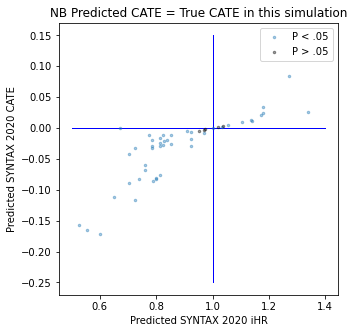

In [16]:
df_1 = df[df.sim_id==1]
df_1 = syntax_iHR_ci(df_1)

plt.figure(figsize=(5,5))
plt.plot([.5,1.4], [0,0], "b-", linewidth=1);
plt.plot([1,1], [-.25,.15], "b-", linewidth=1);
plt.plot(df_1['iHR'][df_1['significance']], df_1['true_cate'][df_1['significance']], 'o', markersize=2.5, alpha=.4, label="P < .05");
plt.plot(df_1['iHR'][~df_1['significance']], df_1['true_cate'][~df_1['significance']],'ko', markersize=2.5, alpha=.4, label="P > .05");
plt.title("NB Predicted CATE = True CATE in this simulation")
plt.xlabel("Predicted SYNTAX 2020 iHR")
plt.ylabel("Predicted SYNTAX 2020 CATE");
plt.legend();

#### A-learning

Matrix format implementation based on Tsiatis et al., Dynamic treatment regime. Statistical methods for precision medicine, eq (3.70) p. 76.

In [17]:
def A_learning(df, ctst_vrb, ps, nu, ttt, y):
    
    """A-learning algorithm
    fits PS and prognostic models through random forest
    Linear contrast function with matrix implementation.
    Outputs a tuple of coefficients for the contrast function and in-sample CATE prediction"""
    
    H = df[ctst_vrb]
    H.insert(0, 'H_0', np.repeat(1, len(H)) )
    
    A = np.empty((len(ctst_vrb)+1, len(ctst_vrb)+1))
    for i in range(len(A)):
        for j in range(len(A)):
            A[i,j] =  np.sum(H.iloc[:,j] * H.iloc[:,i] * (df[ttt] - df[ps]) * df[ttt] )
    try:
        A_inverse = np.linalg.inv(A)
    except np.linalg.LinAlgError:
        A_inverse = float("nan")
        print('Singular matrix, Nan output.')
    C = np.empty((len(ctst_vrb)+1,1))
    
    for i in range(len(C)):
        C[i] = np.sum(H.iloc[:,i] * (df[ttt] - df[ps]) * (df[y] - df[nu])) 
        
    phi_hat = np.dot(A_inverse, C)
    cate_hat = np.dot(H, phi_hat)
    return phi_hat, cate_hat

#### X-learner

Implementation based on Kunzel et al., Metalearners for estimating heterogeneous treatment effects using machine learning, PNAS, 2019 <br>
with random forrest as base learners

In [18]:
def x_learner(df=df, n_trees=100, max_features = "sqrt", e_hat = np.repeat(.5, len(df)),
              pronostic_predictors=[''], ttt='cabg', y='Y'):
    
    """X-learner algorythm with Random Forrest as base learners
    default weighting is e_hat=.5 but may be changed for a PS array"""
    
    try:
        pr_mod = RandomForestClassifier(n_estimators = n_trees, max_features = max_features)

        pr_mod1 = pr_mod.fit(df[df[ttt]==1].loc[:,pronostic_predictors], df[df[ttt]==1].loc[:,y])
        y1_hat = pr_mod1.predict_proba(df.loc[:,pronostic_predictors])[:,1]

        pr_mod0 = pr_mod.fit(df[df[ttt]==0].loc[:,pronostic_predictors], df[df[ttt]==0].loc[:,y])
        y0_hat = pr_mod0.predict_proba(df.loc[:,pronostic_predictors])[:,1]

        cate_imp1 = np.array(df[df[ttt]==1].loc[:,y] - y0_hat[df[ttt]==1])
        cate_imp0 = np.array(y1_hat[df[ttt]==0] - df[df[ttt]==0].loc[:,y])

        pr_mod = RandomForestRegressor(n_estimators=n_trees, max_features = max_features)

        tau1 = pr_mod.fit(df[df[ttt]==1].loc[:,pronostic_predictors], cate_imp1)
        tau1_hat = tau1.predict(df.loc[:,pronostic_predictors])

        tau0 = pr_mod.fit(df[df[ttt]==0].loc[:,pronostic_predictors], cate_imp0)
        tau0_hat = tau0.predict(df.loc[:,pronostic_predictors])

        cate_hat = (e_hat * tau0_hat) + (1 - e_hat) * tau1_hat
        
    except IndexError:
        cate_hat = np.repeat(float("nan"), len(df))
        print('IndexError in Random Forrest fit, Nan output.')
    return cate_hat

#### Define a generic function that will compute $ \hat{e}(x) $ and $ \hat{\tau}(x) $ for all simulated patients
- Uses either X-learner or A-learning as defined above
- PS and prognostic models are fitted through Random Forrests
- Tuning can be provided as `n_trees` and `max_features`
- See docstring for details

In [19]:
def ps_cate_preds(df, n_trees=100, max_features = "sqrt", 
                method='a',
                ttt = 'cabg', y = 'Y',
                ps_predictors = ["age", "crcl_log", "copd", "tvd", "lmcad", "both"],
                pronostic_predictors = ["tvd", "lmcad", "both", "syntax", "age", "crcl", "diabetes", "insulin", "lvef", "smoking", "pvd", "copd"],
                ctst_vrb = ['syntax', 'tvd', 'lmcad'],
                progress=1, step=10):
    
    """Compute PS and CATE from a dataset from method = 'x' or 'a' for X-Learner and A-learning respectively.
    ctst_vrb are the contrast function variables and need only be provided in the case of a learning.
    progress and step are merely printing arguments to follow progression while the function is looped over.
    """
    
    from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
    
    if isinstance(ps_predictors, pd.core.series.Series):
        e_hat = ps_predictors
        #print('PS array provided, no model fitted')
    else:
        ps_mod = RandomForestClassifier(n_estimators = n_trees, max_features = max_features)
        ps_mod = ps_mod.fit(df[ps_predictors], df[ttt])
        e_hat = ps_mod.predict_proba(df[ps_predictors])[:,1]
    
    df_temp = df.copy()
    
    df_temp["e_hat"] = e_hat
    
    if method=="x":
        
        df_temp["cate_hat"] = x_learner(df_temp, n_trees=n_trees, e_hat = df_temp["e_hat"],
                               pronostic_predictors = pronostic_predictors, ttt=ttt, y=y)
    
    elif method=="a":
        pr_mod = RandomForestClassifier(n_estimators = n_trees, max_features = max_features)
        pronostic_predictors.append(ttt)
        pr_mod1 = pr_mod.fit(df.loc[:,pronostic_predictors], df.loc[:,y])
        
        X = df.loc[:,pronostic_predictors]
        X[ttt] = np.repeat(0, len(X))        
        df_temp["y0_hat"] = pr_mod1.predict_proba(X)[:,1]
        
        df_temp["cate_hat"] = A_learning(df = df_temp, ctst_vrb = ctst_vrb, ps = "e_hat", nu = "y0_hat", ttt = ttt, y = y)[1]        
        
        df_temp.drop('y0_hat', axis=1, inplace=True)
        
    if progress % step == 0:
        print(progress)
        
    return df_temp

#### Apply with A-learning on the first dataset
- Contrast function, prognostic and PS models take relevant variables as inputs.

In [27]:
df_A = ps_cate_preds(df=df_1, method= 'a', n_trees=100, max_features = "sqrt", 
                    ttt = 'cabg', y = 'Y',
                    ps_predictors = ["age", "crcl_log", "copd", "tvd", "lmcad", "both"],
                    pronostic_predictors = ["tvd", "lmcad", "both", "syntax", "age", "crcl", "diabetes", "insulin", "lvef", "smoking", "pvd", "copd"],
                    ctst_vrb = ['syntax', 'tvd', 'lmcad'])

#### Apply with X-learner on the first dataset
- Prognostic take relevant variables as inputs, PScores is passed as an array and no model need to be reffitted for computational speed concerns, contrast function needs not be specified.

In [28]:
df_X = ps_cate_preds(df=df_1, method= 'x', n_trees=100, max_features = "sqrt", 
                    ttt = 'cabg', y = 'Y',
                    ps_predictors = df_A.e_hat,
                    pronostic_predictors = ["tvd", "lmcad", "both", "syntax", "age", "crcl", "diabetes", "insulin", "lvef", "smoking", "pvd", "copd"],
                    ctst_vrb = [''])

#### Plot the "Goodness of fit" for the CATEs and PSs

A-learning:
Intercept = -0.011
Slope = -3.223
Pearson = -0.86

X-learner:
Intercept = -0.024
Slope = -0.966
Pearson = -0.376


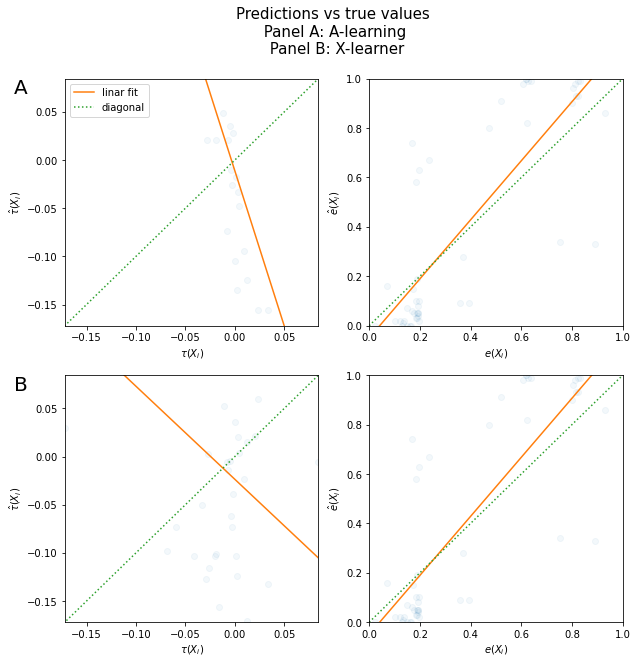

In [29]:
n_points = n

fig, axs = plt.subplots(2, 2, figsize=(10,10))
fig.suptitle('Predictions vs true values \n Panel A: A-learning \n Panel B: X-learner', size=15)

#### A-learning as base learner for the CATE
axs[0,0].text(-0.2, 1, "A", transform=axs[0,0].transAxes, fontsize=20,
        verticalalignment='top')

axs[0,0].plot(df_A["true_cate"][:n_points], df_A["cate_hat"][:n_points], "o", alpha=.05);
axs[0,0].set_xlabel(r'$\tau(X_i)$')
axs[0,0].set_ylabel(r'$\hat{\tau}(X_i)$')

m, b = np.polyfit(df_A["true_cate"][:n_points], df_A["cate_hat"][:n_points], 1)
print('A-learning:')
print("Intercept = "+ str(np.round(b,3)))
print("Slope = "+ str(np.round(m,3)))
from scipy.stats import pearsonr
print("Pearson = " + str(np.round( pearsonr(df_A["true_cate"], df_A["cate_hat"])[0] , 3)) ) 

axs[0,0].plot([min(df_A["true_cate"]), max(df_A["true_cate"])], [m*min(df_A["true_cate"]) + b, m*max(df_A["true_cate"]) + b], label="linar fit")
axs[0,0].plot([-.4,.4], [-.4,.4], linestyle=":", label="diagonal")
axs[0,0].set_xlim([min(df_A["true_cate"]), max(df_A["true_cate"])])
axs[0,0].set_ylim([min(df_A["true_cate"]), max(df_A["true_cate"])])
axs[0,0].legend()


axs[0,1].plot(df_A["cabg_pr"][:n_points], df_A["e_hat"][:n_points], "o", alpha=.05);
axs[0,1].set_xlabel('$e(X_i)$')
axs[0,1].set_ylabel('$\hat{e}(X_i)$');

m, b = np.polyfit(df_A["cabg_pr"], df_A["e_hat"], 1)
axs[0,1].plot([0,1], m*np.array([0,1]) + b)
axs[0,1].plot([0,1], [0,1], linestyle=":", label="diagonal")
axs[0,1].set_xlim([0,1])
axs[0,1].set_ylim([0,1]);

#### X-learner as base learner for the CATE
axs[1,0].text(-0.2, 1, "B", transform=axs[1,0].transAxes, fontsize=20,
        verticalalignment='top')

axs[1,0].plot(df_X["true_cate"][:n_points], df_X["cate_hat"][:n_points], "o", alpha=.05);
axs[1,0].set_xlabel(r'$\tau(X_i)$')
axs[1,0].set_ylabel(r'$\hat{\tau}(X_i)$')

m, b = np.polyfit(df_X["true_cate"][:n_points], df_X["cate_hat"][:n_points], 1)
print('\nX-learner:')
print("Intercept = "+ str(np.round(b,3)))
print("Slope = "+ str(np.round(m,3)))
from scipy.stats import pearsonr
print("Pearson = " + str(np.round( pearsonr(df_X["true_cate"], df_X["cate_hat"])[0] , 3)) ) 

axs[1,0].plot([min(df_X["true_cate"]), max(df_X["true_cate"])], [m*min(df_X["true_cate"]) + b, m*max(df_X["true_cate"]) + b], label="linar fit")
axs[1,0].plot([-.4,.4], [-.4,.4], linestyle=":", label="diagonal")
axs[1,0].set_xlim([min(df_X["true_cate"]), max(df_X["true_cate"])])
axs[1,0].set_ylim([min(df_X["true_cate"]), max(df_X["true_cate"])])


axs[1,1].plot(df_X["cabg_pr"][:n_points], df_X["e_hat"][:n_points], "o", alpha=.05);
axs[1,1].set_xlabel('$e(X_i)$')
axs[1,1].set_ylabel('$\hat{e}(X_i)$');

m, b = np.polyfit(df_X["cabg_pr"], df_X["e_hat"], 1)
axs[1,1].plot([0,1], m*np.array([0,1]) + b)
axs[1,1].plot([0,1], [0,1], linestyle=":", label="diagonal")
axs[1,1].set_xlim([0,1])
axs[1,1].set_ylim([0,1]);

#### Define functions for ARE and ASREs (three stochastic implementations as described below)

In [31]:
def compute_are_hat(df):
    """Compute ARE from a df where e_hat and cate_hat are provided"""
    are_hat = np.mean( ( (df.pred_cate<0) - df.e_hat)*df.cate_hat)
    return are_hat

In [32]:
def compute_r_asre_hat(df, alpha):
    """Compute uniform/random ASRE from a df where e_hat and cate_hat are provided
    alpha is the uniform/random parameter (bounded between 0 and 1) """
    df_temp = df
    df_temp['p_x'] = np.repeat(alpha, len(df))
    r_asre_hat = np.mean( df_temp.p_x * ( (df_temp.pred_cate<0) - df_temp.e_hat)*df_temp.cate_hat)
    return r_asre_hat

In [33]:
def compute_ci_asre_hat(df, alpha):
    """Compute CI ASRE from a df where e_hat and cate_hat are provided"""
    df_temp = syntax_iHR_ci(df, alpha)
    ci_asre_hat = np.mean( df_temp.significance * ( (df_temp.pred_cate<0) - df_temp.e_hat)*df_temp.cate_hat)
    return ci_asre_hat

In [34]:
def legit(x):
    return .5 * np.log((x+1)/(1-x))

def compute_cb_asre_hat(df, alpha):
    """Compute cognitive biais ASRE from a df where e_hat and cate_hat are provided,
    alpha is the cognitive biais parameter (bounded between 0 and 1) """
    df_temp = df
    df_temp['p_x'] = (1 - np.abs( (df_temp['pred_cate']<0) - df_temp['e_hat']) ) ** legit(alpha)
    cb_asre_hat = np.mean( df_temp.p_x * ( (df_temp.pred_cate<0) - df_temp.e_hat)*df_temp.cate_hat)
    return cb_asre_hat

#### Estimate ARE and ASREs in each imputed dataset
##### I/ Create a list of datasets

In [35]:
inds = np.arange(sims)+1

df_list=[]
for i in inds:
    df_list.append(df[df['sim_id']==i])

##### II/ Fit PS & PR random forest models in all `sims` datasets
- Takes time in case of large number of datasets to analyze
- Comprehensive list seems faster than parrallelization through `from multiprocessing import Pool`

a) A-Learning 

In [36]:
dfs_ready_A = [ps_cate_preds(df=data, method= 'a', progress=progress, step=int(sims/10)) for progress, data in enumerate(df_list)]

0
3
6
9
12
15
18
21
24
27


b) X-learner

In [37]:
dfs_ready_X = [ps_cate_preds(df=data, method= 'x', progress=progress, step=int(sims/10)) for progress, data in enumerate(df_list)]

0
3
6
9
12
15
18
21
24
27


##### III/ Now, all ARE / ASREs computations below are instantaneous..

a) A-Learning 

In [38]:
are_hats_A = [compute_are_hat(i) for i in dfs_ready_A]

In [39]:
r_1_3_asre_hats_A = [compute_r_asre_hat(i, alpha=1/3) for i in dfs_ready_A]
r_2_3_asre_hats_A = [compute_r_asre_hat(i, alpha=2/3) for i in dfs_ready_A]

In [40]:
ci_95_asre_hats_A = [compute_ci_asre_hat(i, alpha=.05) for i in dfs_ready_A]
ci_55_asre_hats_A = [compute_ci_asre_hat(i, alpha=.45) for i in dfs_ready_A]

In [41]:
cb_1_3_asre_hats_A = [compute_cb_asre_hat(i, alpha=1/3) for i in dfs_ready_A]
cb_2_3_asre_hats_A = [compute_cb_asre_hat(i, alpha=2/3) for i in dfs_ready_A]

b) X-learner

In [42]:
are_hats_X = [compute_are_hat(i) for i in dfs_ready_X]

In [43]:
r_1_3_asre_hats_X = [compute_r_asre_hat(i, alpha=1/3) for i in dfs_ready_X]
r_2_3_asre_hats_X = [compute_r_asre_hat(i, alpha=2/3) for i in dfs_ready_X]

In [44]:
ci_95_asre_hats_X = [compute_ci_asre_hat(i, alpha=.05) for i in dfs_ready_X]
ci_55_asre_hats_X = [compute_ci_asre_hat(i, alpha=.45) for i in dfs_ready_X]

In [45]:
cb_1_3_asre_hats_X = [compute_cb_asre_hat(i, alpha=1/3) for i in dfs_ready_X]
cb_2_3_asre_hats_X = [compute_cb_asre_hat(i, alpha=2/3) for i in dfs_ready_X]

#### Import true values from `true_val.ipynb`

In [71]:
from ipynb.fs.full.true_val import true_are, true_1_3_r_asre, true_2_3_r_asre, true_95_ci_asre, true_55_ci_asre, true_1_3_cb_asre, true_2_3_cb_asre

#### Plot results

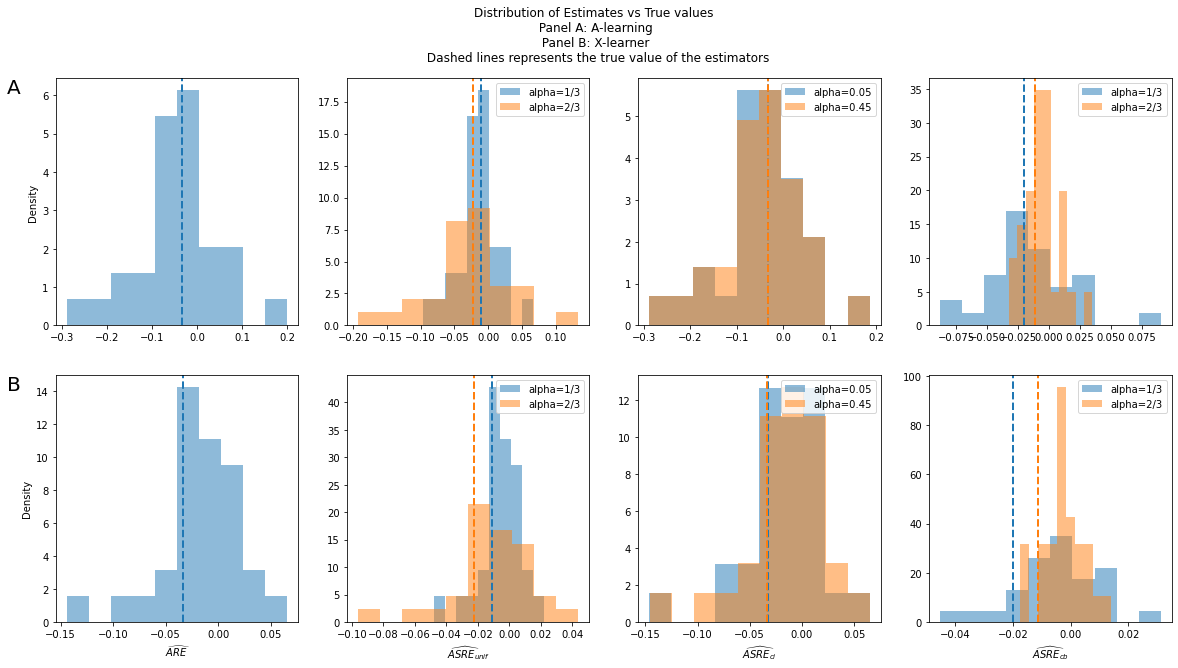

In [47]:
fig, axs = plt.subplots(2, 4, figsize=(20,10))

fig.suptitle('Distribution of Estimates vs True values \n Panel A: A-learning \n Panel B: X-learner \n Dashed lines represents the true value of the estimators')

#### A-learning as base learner for the CATE
axs[0,0].text(-0.2, 1, "A", transform=axs[0,0].transAxes, fontsize=20,
        verticalalignment='top')

axs[0,0].hist(are_hats_A, density=True, alpha=.5);
axs[0,0].set_ylabel('Density');
axs[0,0].axvline(true_are, color='tab:blue', linestyle='dashed', linewidth=2)

axs[0,1].hist(r_1_3_asre_hats_A, density=True, alpha=.5, label="alpha=1/3");
axs[0,1].axvline(true_1_3_r_asre, color='tab:blue', linestyle='dashed', linewidth=2)
axs[0,1].hist(r_2_3_asre_hats_A, density=True, alpha=.5, label="alpha=2/3");
axs[0,1].axvline(true_2_3_r_asre, color='tab:orange', linestyle='dashed', linewidth=2)
axs[0,1].legend(loc='upper right')

axs[0,2].hist(ci_95_asre_hats_A, density=True, alpha=.5, label="alpha=0.05");
axs[0,2].axvline(true_95_ci_asre, color='tab:blue', linestyle='dashed', linewidth=2)
axs[0,2].hist(ci_55_asre_hats_A, density=True, alpha=.5, label="alpha=0.45");
axs[0,2].axvline(true_55_ci_asre, color='tab:orange', linestyle='dashed', linewidth=2)
axs[0,2].legend(loc='upper right')

axs[0,3].hist(cb_1_3_asre_hats_A, density=True, alpha=.5, label="alpha=1/3");
axs[0,3].axvline(true_1_3_cb_asre, color='tab:blue', linestyle='dashed', linewidth=2)
axs[0,3].hist(cb_2_3_asre_hats_A, density=True, alpha=.5, label="alpha=2/3");
axs[0,3].axvline(true_2_3_cb_asre, color='tab:orange', linestyle='dashed', linewidth=2)
axs[0,3].legend(loc='upper right');

#### X-learner as base learner for the CATE
axs[1,0].text(-0.2, 1, "B", transform=axs[1,0].transAxes, fontsize=20,
        verticalalignment='top')

axs[1,0].hist(are_hats_X, density=True, alpha=.5);
axs[1,0].set_xlabel('$\widehat{ARE}$');
axs[1,0].set_ylabel('Density');
axs[1,0].axvline(true_are, color='tab:blue', linestyle='dashed', linewidth=2)

axs[1,1].hist(r_1_3_asre_hats_X, density=True, alpha=.5, label="alpha=1/3");
axs[1,1].axvline(true_1_3_r_asre, color='tab:blue', linestyle='dashed', linewidth=2)
axs[1,1].hist(r_2_3_asre_hats_X, density=True, alpha=.5, label="alpha=2/3");
axs[1,1].axvline(true_2_3_r_asre, color='tab:orange', linestyle='dashed', linewidth=2)
axs[1,1].set_xlabel('$\widehat{ASRE}_{unif}$');
axs[1,1].legend(loc='upper right')

axs[1,2].hist(ci_95_asre_hats_X, density=True, alpha=.5, label="alpha=0.05");
axs[1,2].axvline(true_95_ci_asre, color='tab:blue', linestyle='dashed', linewidth=2)
axs[1,2].hist(ci_55_asre_hats_X, density=True, alpha=.5, label="alpha=0.45");
axs[1,2].axvline(true_55_ci_asre, color='tab:orange', linestyle='dashed', linewidth=2)
axs[1,2].set_xlabel('$\widehat{ASRE}_{ci}$');
axs[1,2].legend(loc='upper right')

axs[1,3].hist(cb_1_3_asre_hats_X, density=True, alpha=.5, label="alpha=1/3");
axs[1,3].axvline(true_1_3_cb_asre, color='tab:blue', linestyle='dashed', linewidth=2)
axs[1,3].hist(cb_2_3_asre_hats_X, density=True, alpha=.5, label="alpha=2/3");
axs[1,3].axvline(true_2_3_cb_asre, color='tab:orange', linestyle='dashed', linewidth=2)
axs[1,3].set_xlabel('$\widehat{ASRE}_{cb}$');
axs[1,3].legend(loc='upper right');

#### Relation between alpha and ASRE in each of the three three stochastic implementation scenarios

In [48]:
#alphas = np.linspace(.0001,.9999,1000)
alphas = np.logspace(np.log10(1e-15), np.log10(.9999), 1000)

r_asre_hat_alphas = [compute_r_asre_hat(dfs_ready_A[0], alpha) for alpha in alphas]
ci_asre_hat_alphas = [compute_ci_asre_hat(dfs_ready_A[0], alpha) for alpha in alphas]
cb_asre_hat_alphas =[compute_cb_asre_hat(dfs_ready_A[0], alpha) for alpha in alphas]

are_hat = compute_are_hat(dfs_ready_A[0])

In [49]:
def compute_ci_px(df, alpha):
    """Returns p(x)s for CI ASRE from a df
    alpha is type I error"""
    significance = syntax_iHR_ci(df, alpha)['significance']
    return significance

def compute_cb_px(df, alpha):
    """Returns p(x)s for compute cognitive biais ASRE from a df where e_hat and cate_hat are provided,
    alpha is the cognitive biais parameter (bounded between 0 and 1) """
    df_temp = df
    df_temp['p_x'] = (1 - np.abs( (df_temp['pred_cate']<0) - df_temp['e_hat']) ) ** legit(alpha)
    return df_temp['p_x']

ci_mean_px_alphas = [np.mean(compute_ci_px(dfs_ready_A[0], alpha)) for alpha in alphas]
cb_mean_px_alphas = [np.mean(compute_cb_px(dfs_ready_A[0], alpha)) for alpha in alphas]

##### Compute true values fo ARE & ASREs

In [50]:
def compute_are_true(df):
    """Compute ARE from the true ps and cate"""
    are_true = np.mean( ( (df.pred_cate<0) - df.cabg_pr)*df.true_cate)
    return are_true

def compute_r_asre_true(df, alpha):
    """Compute uniform/random ASRE from the true ps and cate
    alpha is the uniform/random parameter (bounded between 0 and 1) """
    df_temp = df
    df_temp['p_x'] = np.repeat(alpha, len(df))
    r_asre_true = np.mean( df_temp.p_x * ( (df_temp.pred_cate<0) - df_temp.cabg_pr)*df_temp.true_cate)
    return r_asre_true

def compute_ci_asre_true(df, alpha):
    """Compute CI ASRE from the true ps and cate"""
    df_temp = syntax_iHR_ci(df, alpha)
    ci_asre_true = np.mean( df_temp.significance * ( (df_temp.pred_cate<0) - df_temp.cabg_pr)*df_temp.true_cate)
    return ci_asre_true

def compute_cb_asre_true(df, alpha):
    """Compute cognitive biais ASRE from the true ps and cate
    alpha is the cognitive biais parameter (bounded between 0 and 1) """
    df_temp = df
    df_temp['p_x'] = (1 - np.abs( (df_temp['pred_cate']<0) - df_temp['cabg_pr']) ) ** legit(alpha)
    cb_asre_true = np.mean( df_temp.p_x * ( (df_temp.pred_cate<0) - df_temp.cabg_pr)*df_temp.true_cate)
    return cb_asre_true

are_true = compute_are_true(dfs_ready_A[0])
r_asre_alphas_true = [compute_r_asre_true(dfs_ready_A[0], alpha) for alpha in alphas]
ci_asre_alphas_true = [compute_ci_asre_true(dfs_ready_A[0], alpha) for alpha in alphas]
cb_asre_alphas_true = [compute_cb_asre_true(dfs_ready_A[0], alpha) for alpha in alphas]

##### Compute fraction of population following the rule under true cognitive biais (from true PS)

In [51]:
def compute_cb_px_true(df, alpha):
    """Returns p(x)s for compute cognitive biais ASRE from a df where e_hat and cate_hat are provided,
    alpha is the cognitive biais parameter (bounded between 0 and 1) """
    df_temp = df
    df_temp['p_x'] = (1 - np.abs( (df_temp['pred_cate']<0) - df_temp['cabg_pr']) ) ** legit(alpha)
    return df_temp['p_x']

cb_mean_px_alphas_true = [np.mean(compute_cb_px_true(dfs_ready_A[0], alpha)) for alpha in alphas]

##### Plot results

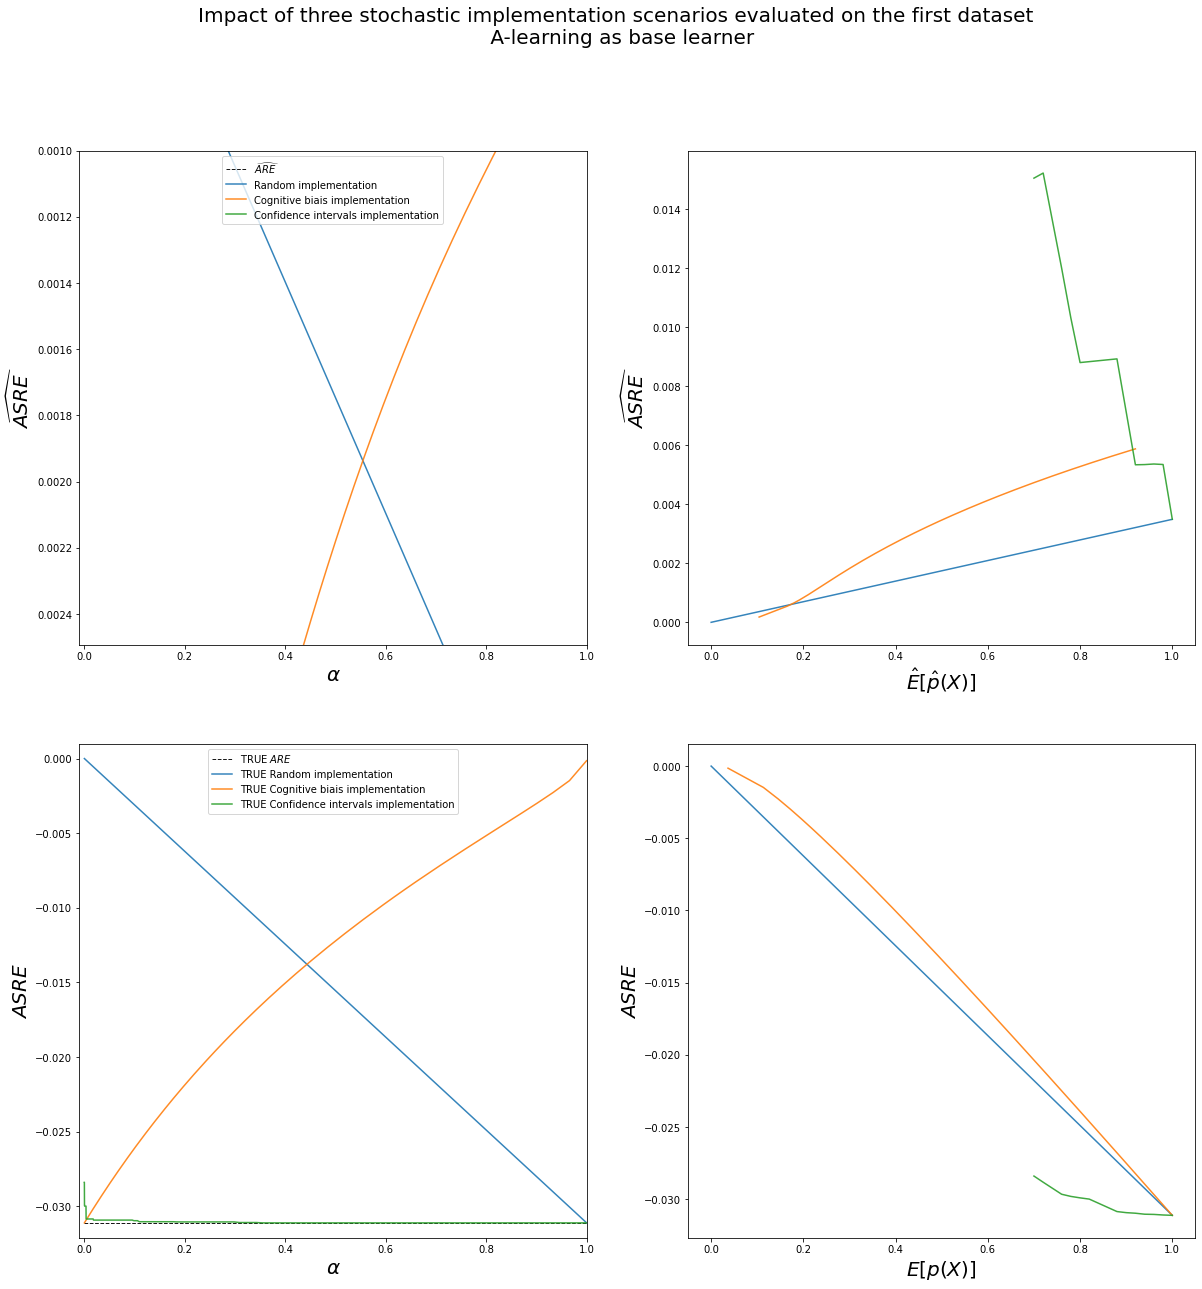

In [52]:
fig, axs = plt.subplots(2, 2, figsize=(20,20))

fig.suptitle("Impact of three stochastic implementation scenarios evaluated on the first dataset \n A-learning as base learner", fontsize=20)
#ax1.plot([0,1],[0, 0], color= "black", alpha=1, linewidth=.5, linestyle='solid')

axs[0,0].plot([0,1],[are_hat, are_hat], color= "black", alpha=.9, linewidth=1, linestyle='dashed', label=r'$\widehat{ARE}$')
axs[0,0].plot(alphas, r_asre_hat_alphas, color= "tab:blue", alpha=.9, label="Random implementation",)
axs[0,0].plot(alphas, cb_asre_hat_alphas, color= "tab:orange", alpha=.9, label="Cognitive biais implementation")
axs[0,0].plot(alphas, ci_asre_hat_alphas, color= "tab:green", alpha=.9, label="Confidence intervals implementation")

axs[0,0].set_xlabel(r'$\alpha$', fontsize=20)
axs[0,0].set_ylabel(r'$\widehat{ASRE}$', fontsize=20)
axs[0,0].legend(loc='upper center');

axs[0,0].set_xlim([-.01,1])
axs[0,0].set_ylim([are_hat-.001,.001])

axs[1,0].plot([0,1],[are_true, are_true], color= "black", alpha=.9, linewidth=1, linestyle='dashed', label='TRUE $ARE$')
axs[1,0].plot(alphas, r_asre_alphas_true, color= "tab:blue", alpha=.9, label="TRUE Random implementation")
axs[1,0].plot(alphas, cb_asre_alphas_true, color= "tab:orange", alpha=.9, label="TRUE Cognitive biais implementation")
axs[1,0].plot(alphas, ci_asre_alphas_true, color= "tab:green", alpha=.9, label="TRUE Confidence intervals implementation")

axs[1,0].set_xlabel(r'$\alpha$', fontsize=20)
axs[1,0].set_ylabel(r'$ASRE$', fontsize=20)
axs[1,0].legend(loc='upper center');

axs[1,0].set_xlim([-.01,1])
axs[1,0].set_ylim([are_true-.001,.001])

axs[0,1].plot(alphas, r_asre_hat_alphas, "-", alpha=.9)
axs[0,1].plot(cb_mean_px_alphas, cb_asre_hat_alphas, "-", alpha=.9)
axs[0,1].plot(ci_mean_px_alphas, ci_asre_hat_alphas, "-", alpha=.9)

axs[0,1].set_xlabel(r'$\hat{E}[\hat{p}(X)]$', fontsize=20)
axs[0,1].set_ylabel(r'$\widehat{ASRE}$', fontsize=20)

#axs[0,1].set_xlim([.9,1])
#axs[0,1].set_ylim([are_hat,-.027]);

axs[1,1].plot(alphas, r_asre_alphas_true, color= "tab:blue", alpha=.9, label="TRUE Random implementation")
axs[1,1].plot(cb_mean_px_alphas_true, cb_asre_alphas_true, color= "tab:orange", alpha=.9, label="TRUE Cognitive biais implementation")
axs[1,1].plot(ci_mean_px_alphas, ci_asre_alphas_true, color= "tab:green", alpha=.9, label="TRUE Confidence intervals implementation")

axs[1,1].set_xlabel(r'$E[p(X)]$', fontsize=20)
axs[1,1].set_ylabel(r'$ASRE$', fontsize=20);

#axs[1,1].set_xlim([.9,1])
#axs[1,1].set_ylim([are_true,-.033]);

##### Zoom in on the bottom right figure

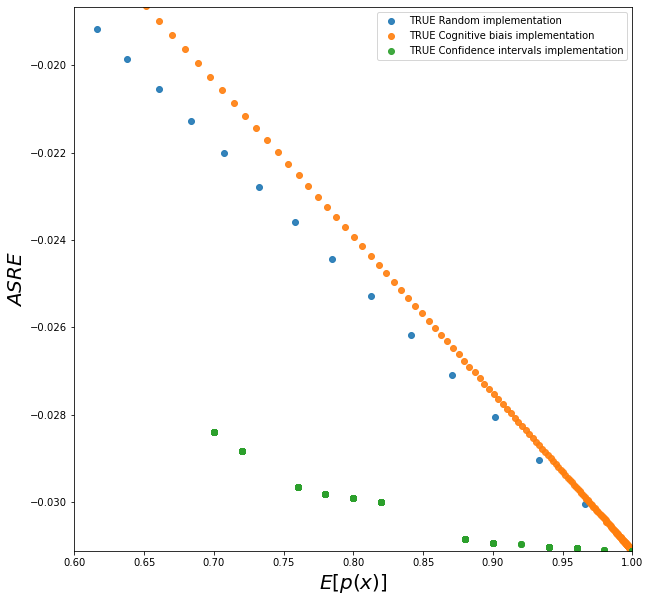

In [53]:
plt.figure(figsize=(10,10))
plt.plot(alphas, r_asre_alphas_true, "o", color= "tab:blue", alpha=.9, label="TRUE Random implementation")
plt.plot(cb_mean_px_alphas_true, cb_asre_alphas_true, "o", color= "tab:orange", alpha=.9, label="TRUE Cognitive biais implementation")
plt.plot(ci_mean_px_alphas, ci_asre_alphas_true, "o", color= "tab:green", alpha=.9, label="TRUE Confidence intervals implementation")
plt.xlim((.6,1))
plt.ylim((are_true, .6*are_true))
plt.legend()

plt.xlabel(r'$E[p(x)]$', fontsize=20)
plt.ylabel(r'$ASRE$', fontsize=20);


- Note that $ E[p(X)] $ can be interpreted as the fraction of the population following the rule

#### Bootstrap confidence intervals of $ \widehat{ARE} $ and $ \widehat {ASRE} $s

In [54]:
random.seed(4561) # Set seed for reproductibility.

n_boots = 200 # Number of boostrap iterations.

# Generate resampling indexes.
resamples = []
for n_boot in range(n_boots):
    resamples.append([random.randint(0,n-1) for _ in range(n)])

##### I/ Check nominal coverage in the case where $ \hat{\tau}(x)$ is estimated via A-learning
- Compute all the information required in each boostrap resample

In [55]:
boot_computed_A = []    
for it, resample in enumerate(resamples):
    boot_computed_A.append( [ps_cate_preds(df=data.iloc[resample], method= 'a', progress=1) for data in df_list] )
    perc = int(100*it/n_boot)
    if perc % 5 == 0:
        print("Iteration "+ str(it) + " i.e., " + str(perc)+"%")

Singular matrix, Nan output.
Singular matrix, Nan output.
Singular matrix, Nan output.
Iteration 0 i.e., 0%
Singular matrix, Nan output.
Singular matrix, Nan output.
Singular matrix, Nan output.
Singular matrix, Nan output.
Singular matrix, Nan output.
Singular matrix, Nan output.
Singular matrix, Nan output.
Iteration 5 i.e., 55%
Singular matrix, Nan output.
Singular matrix, Nan output.
Singular matrix, Nan output.
Singular matrix, Nan output.
Singular matrix, Nan output.
Singular matrix, Nan output.
Singular matrix, Nan output.
Iteration 9 i.e., 100%


- Compute bootstrap estimates for all estimators

In [56]:
are_boots_A = np.ones((n_boots, sims))

asre_r_1_3_boots_A = np.ones((n_boots, sims))
asre_r_2_3_boots_A = np.ones((n_boots, sims))

asre_cb_1_3_boots_A = np.ones((n_boots, sims))
asre_cb_2_3_boots_A = np.ones((n_boots, sims))

asre_ci_95_boots_A = np.ones((n_boots, sims))
asre_ci_55_boots_A = np.ones((n_boots, sims))

for boot_i in range(n_boots):
    are_boots_A[boot_i] = np.array( [compute_are_hat(data) for data in boot_computed_A[boot_i]] )
    
    asre_r_1_3_boots_A[boot_i] = np.array( [compute_r_asre_hat(data, alpha=1/3) for data in boot_computed_A[boot_i]])
    asre_r_2_3_boots_A[boot_i] = np.array( [compute_r_asre_hat(data, alpha=2/3) for data in boot_computed_A[boot_i]])
    
    asre_cb_1_3_boots_A[boot_i] = np.array( [compute_cb_asre_hat(data, alpha=1/3) for data in boot_computed_A[boot_i]])
    asre_cb_2_3_boots_A[boot_i] = np.array( [compute_cb_asre_hat(data, alpha=2/3) for data in boot_computed_A[boot_i]])
    
    asre_ci_95_boots_A[boot_i] = np.array( [compute_ci_asre_hat(data, alpha=.05) for data in boot_computed_A[boot_i]])
    asre_ci_55_boots_A[boot_i] = np.array( [compute_ci_asre_hat(data, alpha=.45) for data in boot_computed_A[boot_i]])
    
    perc = int(100*boot_i/n_boot)
    if perc % 5 == 0:
        print("Iteration "+ str(boot_i) + " i.e., " + str(perc)+"%")

Iteration 0 i.e., 0%
Iteration 5 i.e., 55%
Iteration 9 i.e., 100%


- Investigate asymptotic normality of bootstrap estimates in the first dataset

a) Compute original sample estimations for the first dataset

In [57]:
df_computed_A = ps_cate_preds(df=df_list[0], method= 'a', progress=1)

are_A = compute_are_hat(df_computed_A)
    
asre_r_1_3_A = compute_r_asre_hat(df_computed_A, alpha=1/3 )
asre_r_2_3_A = compute_r_asre_hat(df_computed_A, alpha=2/3 )
    
asre_cb_1_3_A = compute_cb_asre_hat(df_computed_A, alpha=1/3 )
asre_cb_2_3_A = compute_cb_asre_hat(df_computed_A, alpha=2/3 )
    
asre_ci_95_A = compute_ci_asre_hat(df_computed_A, alpha=.05 )
asre_ci_55_A = compute_ci_asre_hat(df_computed_A, alpha=.45 )


b) Plot Empirical Bootstrap Distribution as bootstrap percentile method is improper <br>
John Rice, Mathematical Statistics and Data Analysis, 3rd edition, p. 285.

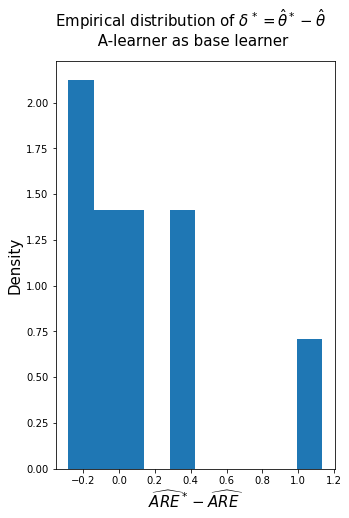

In [58]:
plt.figure(figsize=(5,7.5))
plt.suptitle(r"Empirical distribution of $ \delta^*=\hat{\theta}^*-\hat{\theta} $" "\n A-learner as base learner", fontsize=15)

plt.hist(are_boots_A[:,0] - are_A, density=True);
plt.xlabel(r'$\widehat{ARE}^*-\widehat{ARE}$', fontsize=15);
plt.ylabel('Density', fontsize=15);

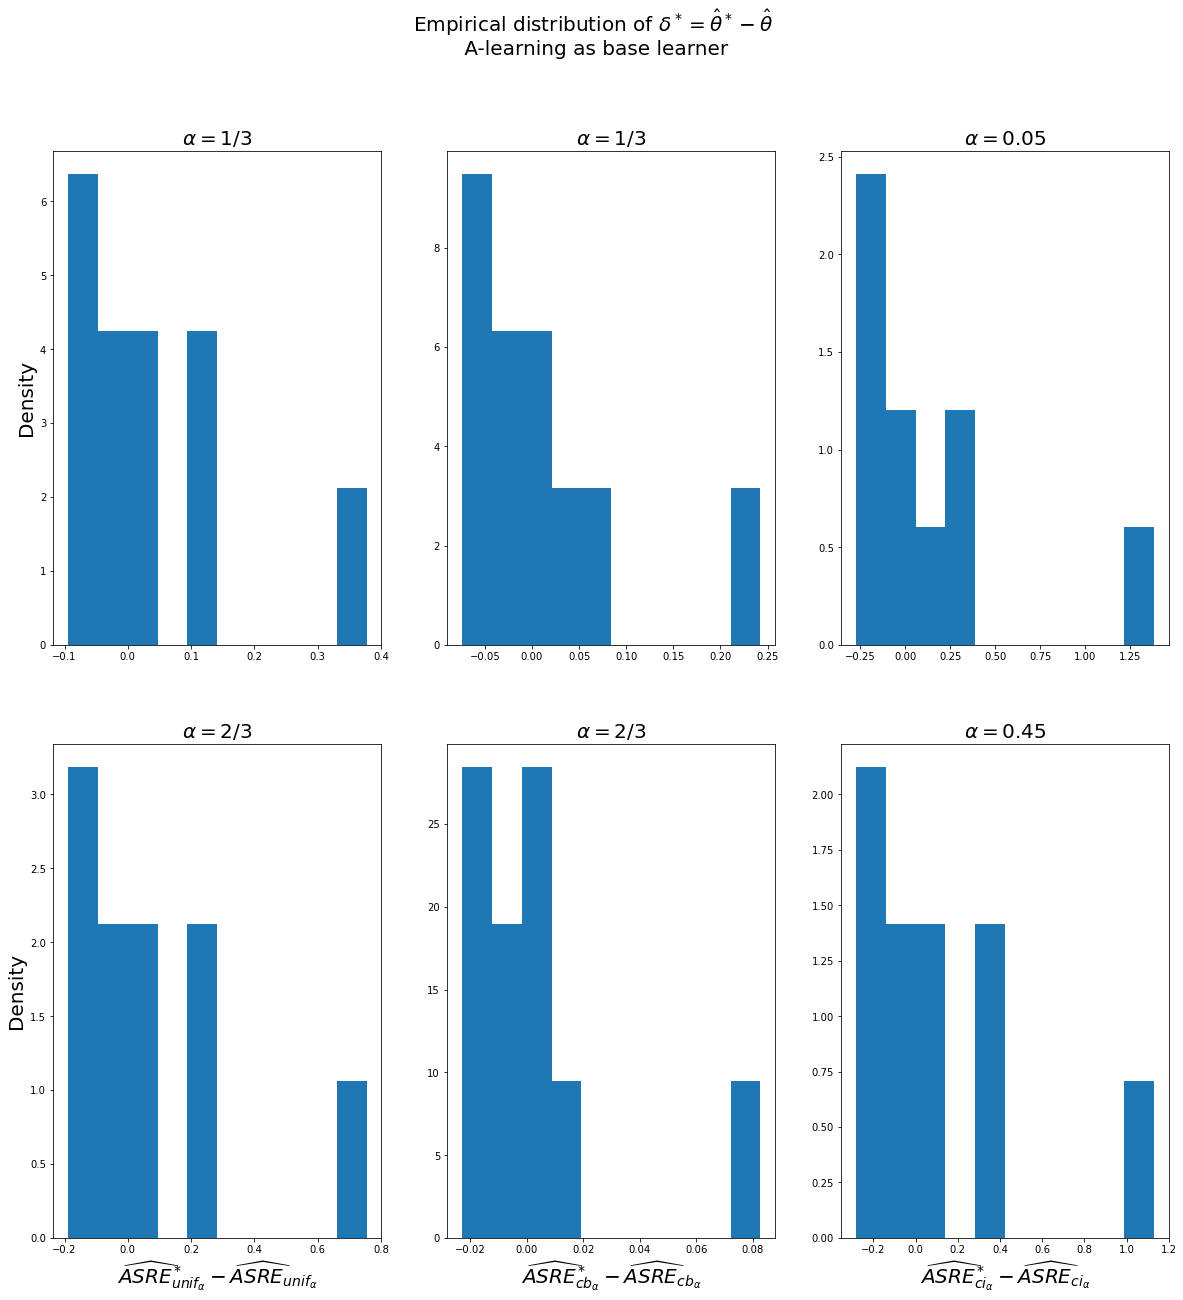

In [59]:
fig, axs = plt.subplots(2, 3, figsize=(20,20))
fig.suptitle(r"Empirical distribution of $ \delta^*=\hat{\theta}^*-\hat{\theta} $" "\n A-learning as base learner", fontsize=20)

axs[0,0].hist(asre_r_1_3_boots_A[:,0] - asre_r_1_3_A, density=True);
axs[0,0].set_title(r'$\alpha=1/3}$', fontsize=20)
axs[0,0].set_ylabel('Density', fontsize=20)

axs[1,0].hist(asre_r_2_3_boots_A[:,0] - asre_r_2_3_A, density=True) ;
axs[1,0].set_title(r'$\alpha=2/3}$', fontsize=20)
axs[1,0].set_xlabel(r'$\widehat{ASRE}_{unif_\alpha}^*-\widehat{ASRE}_{unif_\alpha}$', fontsize=20)
axs[1,0].set_ylabel('Density', fontsize=20)

axs[0,1].hist(asre_cb_1_3_boots_A[:,0] - asre_cb_1_3_A, density=True) ;
axs[0,1].set_title(r'$\alpha=1/3}$', fontsize=20)
axs[1,1].hist(asre_cb_2_3_boots_A[:,0] - asre_cb_2_3_A, density=True) ;
axs[1,1].set_title(r'$\alpha=2/3}$', fontsize=20)
axs[1,1].set_xlabel(r'$\widehat{ASRE}_{cb_\alpha}^*-\widehat{ASRE}_{cb_\alpha}$', fontsize=20)

axs[0,2].hist(asre_ci_95_boots_A[:,0] - asre_ci_95_A, density=True) ;
axs[0,2].set_title(r'$\alpha=0.05}$', fontsize=20)
axs[1,2].hist(asre_ci_55_boots_A[:,0] - asre_ci_55_A, density=True) ;
axs[1,2].set_title(r'$\alpha=0.45}$', fontsize=20)
axs[1,2].set_xlabel(r'$\widehat{ASRE}_{ci_\alpha}^*-\widehat{ASRE}_{ci_\alpha}$', fontsize=20);

- Compute empirical bootstrap CI for all $N=$`sims` datasets through the `empirical_boot_ci`function

- Empirirical bootstrap confidence intervals are $ [2 \hat{\theta} - q_{1 - \alpha/2} ; 2 \hat{\theta} - q_{\alpha/2}  ] $  as described in <br>
John Rice, Mathematical Statistics and Data Analysis, 3rd edition, p. 285.

- Calculate coverage for 95% empirirical bootstrap confidence intervals

In [60]:
def empirical_boot_ci(estimate, boot_estimates, risk_a):
    """outputs a list of empirical bootstrap CI from a list of estimates and a list of lists of bootstrap estimates"""
    quantiles = np.array([np.nanquantile(boot_estimates[:,dataset],[1-risk_a/2, risk_a/2]) for dataset in range(len(estimate))])
    return np.multiply(2,estimate).reshape(len(estimate),1)-quantiles

In [61]:
def coverage(true_value, estimate, boot_estimates, risk_a = .05):
    """outputs coverage from the true value of an estimator (scalar) and a (n_simulation * 2) matrix of confidence intervals"""
    
    ci_matrix = empirical_boot_ci(estimate=estimate, boot_estimates=boot_estimates, risk_a=risk_a)
    return np.sum([ bound[0] < true_value < bound[1] for bound in ci_matrix ]) / len(estimate)

In [62]:
cov_are_A = coverage(true_are, are_hats_A, are_boots_A, risk_a = .05)

cov_asre_r_1_3_A = coverage(true_1_3_r_asre, r_1_3_asre_hats_A, asre_r_1_3_boots_A, risk_a = .05) 
cov_asre_r_2_3_A = coverage(true_2_3_r_asre, r_2_3_asre_hats_A, asre_r_2_3_boots_A, risk_a = .05) 

cov_asre_cb_1_3_A = coverage(true_1_3_cb_asre, cb_1_3_asre_hats_A, asre_cb_1_3_boots_A, risk_a = .05) 
cov_asre_cb_2_3_A = coverage(true_2_3_cb_asre, cb_2_3_asre_hats_A, asre_cb_2_3_boots_A, risk_a = .05) 

cov_asre_ci_95_A = coverage(true_95_ci_asre, ci_95_asre_hats_A, asre_ci_95_boots_A, risk_a = .05) 
cov_asre_ci_55_A = coverage(true_55_ci_asre, ci_55_asre_hats_A, asre_ci_55_boots_A, risk_a = .05) 

- print the results for the 7 estimators considered

In [63]:
print(cov_are_A, cov_asre_r_1_3_A, cov_asre_r_2_3_A, cov_asre_cb_1_3_A, cov_asre_cb_2_3_A, cov_asre_ci_95_A, cov_asre_ci_55_A)

0.8333333333333334 0.8333333333333334 0.8333333333333334 0.6666666666666666 0.5666666666666667 0.8333333333333334 0.8333333333333334


##### II/ Coverage check in the case where $ \hat{\tau}(x)$ is estimated via X-learner
- Compute all the information required in each boostrap resample
- To speed up computation PS models are not refitted and we re-use the predictions from PS models fitted during the A-learner procedure

In [64]:
boot_computed_X = []    
for it, resample in enumerate(resamples):
    boot_computed_X.append( [ps_cate_preds(df=data.iloc[resample], method= 'x', ps_predictors=boot_computed_A[it][dataset_id].e_hat, progress=1) for dataset_id, data in enumerate(df_list)] )
    perc = int(100*it/n_boot)
    if perc % 5 == 0:
        print("Iteration "+ str(it) + " i.e., " + str(perc)+"%")

IndexError in Random Forrest fit, Nan output.
IndexError in Random Forrest fit, Nan output.
IndexError in Random Forrest fit, Nan output.
Iteration 0 i.e., 0%
IndexError in Random Forrest fit, Nan output.
IndexError in Random Forrest fit, Nan output.
IndexError in Random Forrest fit, Nan output.
IndexError in Random Forrest fit, Nan output.
Iteration 5 i.e., 55%
IndexError in Random Forrest fit, Nan output.
IndexError in Random Forrest fit, Nan output.
IndexError in Random Forrest fit, Nan output.
IndexError in Random Forrest fit, Nan output.
IndexError in Random Forrest fit, Nan output.
Iteration 9 i.e., 100%


- Compute bootstrap estimates for all estimators

In [65]:
are_boots_X = np.ones((n_boots, sims))

asre_r_1_3_boots_X = np.ones((n_boots, sims))
asre_r_2_3_boots_X = np.ones((n_boots, sims))

asre_cb_1_3_boots_X = np.ones((n_boots, sims))
asre_cb_2_3_boots_X = np.ones((n_boots, sims))

asre_ci_95_boots_X = np.ones((n_boots, sims))
asre_ci_55_boots_X = np.ones((n_boots, sims))

for boot_i in range(n_boots):
    are_boots_X[boot_i] = np.array( [compute_are_hat(data) for data in boot_computed_A[boot_i]] )
    
    asre_r_1_3_boots_X[boot_i] = np.array( [compute_r_asre_hat(data, alpha=1/3) for data in boot_computed_X[boot_i]])
    asre_r_2_3_boots_X[boot_i] = np.array( [compute_r_asre_hat(data, alpha=2/3) for data in boot_computed_X[boot_i]])
    
    asre_cb_1_3_boots_X[boot_i] = np.array( [compute_cb_asre_hat(data, alpha=1/3) for data in boot_computed_X[boot_i]])
    asre_cb_2_3_boots_X[boot_i] = np.array( [compute_cb_asre_hat(data, alpha=2/3) for data in boot_computed_X[boot_i]])
    
    asre_ci_95_boots_X[boot_i] = np.array( [compute_ci_asre_hat(data, alpha=.05) for data in boot_computed_X[boot_i]])
    asre_ci_55_boots_X[boot_i] = np.array( [compute_ci_asre_hat(data, alpha=.45) for data in boot_computed_X[boot_i]])
    
    perc = int(100*boot_i/n_boot)
    if perc % 5 == 0:
        print("Iteration "+ str(boot_i) + " i.e., " + str(perc)+"%")

Iteration 0 i.e., 0%
Iteration 5 i.e., 55%
Iteration 9 i.e., 100%


- Investigate asymptotic normality of bootstrap estimates in the first dataset

a) Compute original sample estimations for the first dataset

In [66]:
df_computed_X = ps_cate_preds(df=df_list[0], method= 'x')

are_X = compute_are_hat(df_computed_X)
    
asre_r_1_3_X = compute_r_asre_hat(df_computed_X, alpha=1/3 )
asre_r_2_3_X = compute_r_asre_hat(df_computed_X, alpha=2/3 )
    
asre_cb_1_3_X = compute_cb_asre_hat(df_computed_X, alpha=1/3 )
asre_cb_2_3_X = compute_cb_asre_hat(df_computed_X, alpha=2/3 )
    
asre_ci_95_X = compute_ci_asre_hat(df_computed_X, alpha=.05 )
asre_ci_55_X = compute_ci_asre_hat(df_computed_X, alpha=.45 )



b) Plot Empirical Bootstrap Distribution as bootstrap percentile method is improper <br>
John Rice, Mathematical Statistics and Data Analysis, 3rd edition, p. 285.

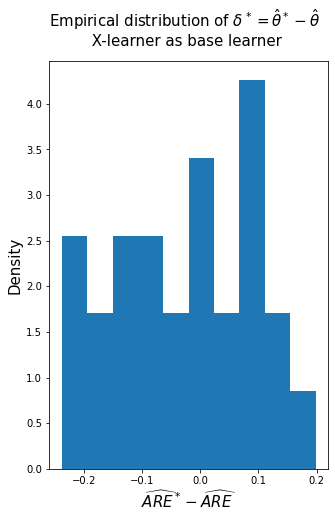

In [67]:
plt.figure(figsize=(5,7.5))
plt.suptitle(r"Empirical distribution of $ \delta^*=\hat{\theta}^*-\hat{\theta} $" "\n X-learner as base learner", fontsize=15)

plt.hist(are_boots_X[0] - are_X, density=True);
plt.xlabel(r'$\widehat{ARE}^*-\widehat{ARE}$', fontsize=15);
plt.ylabel('Density', fontsize=15);

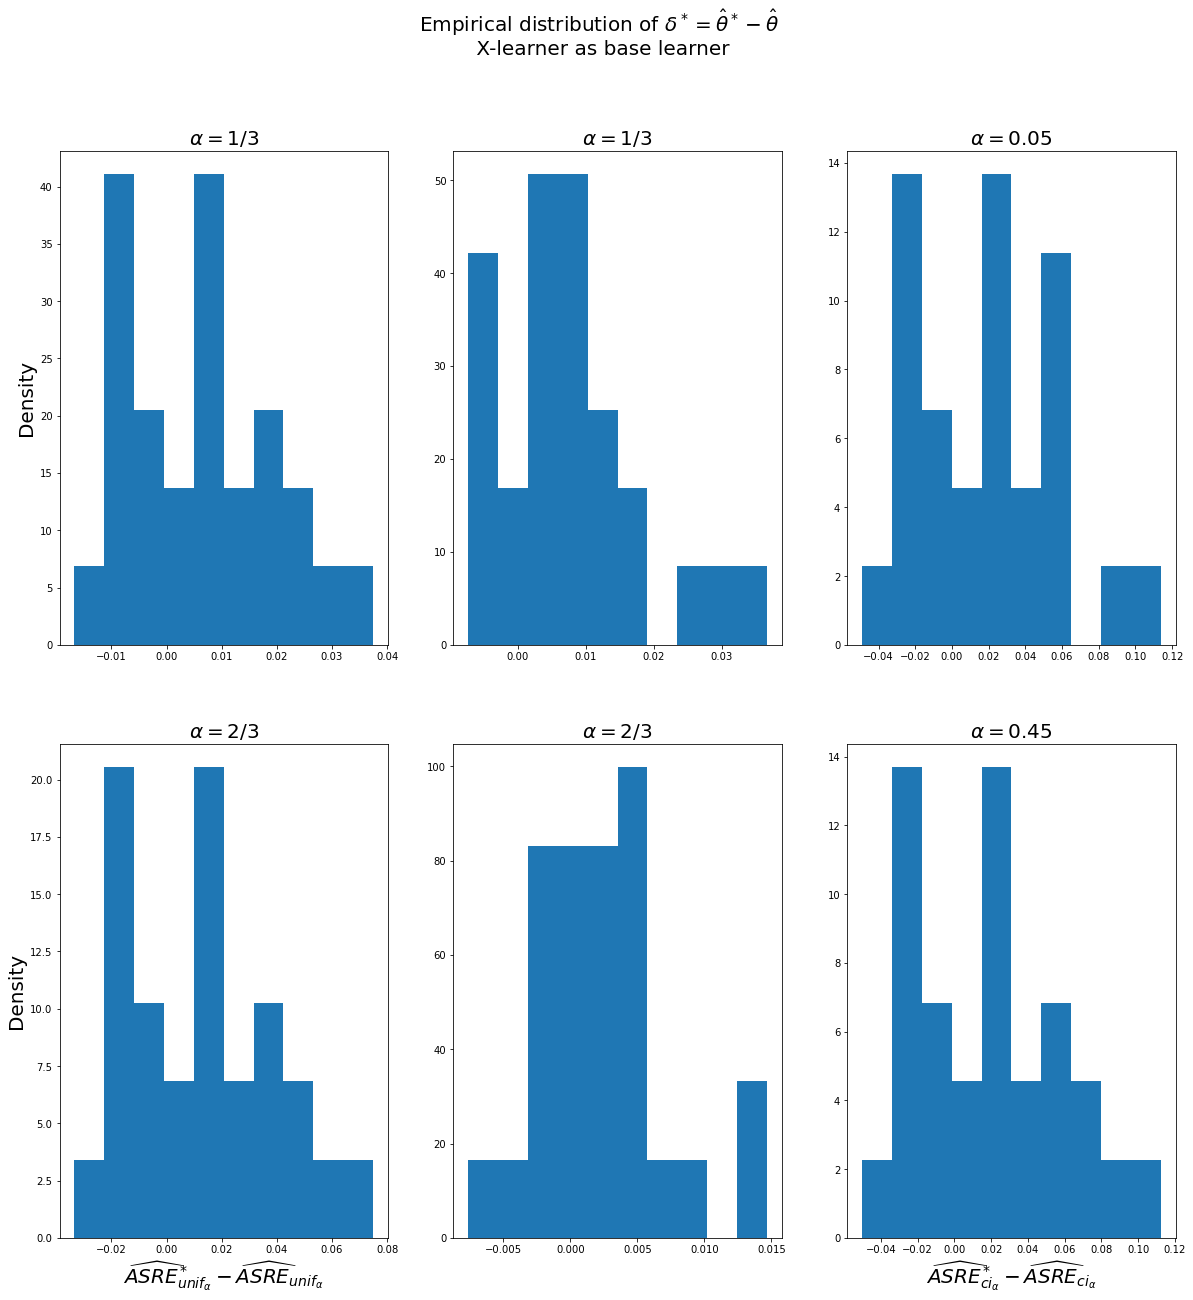

In [68]:
fig, axs = plt.subplots(2, 3, figsize=(20,20))
fig.suptitle(r"Empirical distribution of $ \delta^*=\hat{\theta}^*-\hat{\theta} $" "\n X-learner as base learner", fontsize=20)

axs[0,0].hist(asre_r_1_3_boots_X[0] - asre_r_1_3_X, density=True);
axs[0,0].set_title(r'$\alpha=1/3}$', fontsize=20)
axs[0,0].set_ylabel('Density', fontsize=20)

axs[1,0].hist(asre_r_2_3_boots_X[0] - asre_r_2_3_X, density=True) ;
axs[1,0].set_title(r'$\alpha=2/3}$', fontsize=20)
axs[1,0].set_xlabel(r'$\widehat{ASRE}_{unif_\alpha}^*-\widehat{ASRE}_{unif_\alpha}$', fontsize=20)
axs[1,0].set_ylabel('Density', fontsize=20)

axs[0,1].hist(asre_cb_1_3_boots_X[0] - asre_cb_1_3_X, density=True) ;
axs[0,1].set_title(r'$\alpha=1/3}$', fontsize=20)
axs[1,1].hist(asre_cb_2_3_boots_X[0] - asre_cb_2_3_X, density=True) ;
axs[1,1].set_title(r'$\alpha=2/3}$', fontsize=20)
axs[1,2].set_xlabel(r'$\widehat{ASRE}_{cb_\alpha}^*-\widehat{ASRE}_{cb_\alpha}$', fontsize=20);

axs[0,2].hist(asre_ci_95_boots_X[0] - asre_ci_95_X, density=True) ;
axs[0,2].set_title(r'$\alpha=0.05}$', fontsize=20)
axs[1,2].hist(asre_ci_55_boots_X[0] - asre_ci_55_X, density=True) ;
axs[1,2].set_title(r'$\alpha=0.45}$', fontsize=20)
axs[1,2].set_xlabel(r'$\widehat{ASRE}_{ci_\alpha}^*-\widehat{ASRE}_{ci_\alpha}$', fontsize=20);

- Calculate coverage for 95% empirirical bootstrap confidence intervals

In [69]:
cov_are_X = coverage(true_are, are_hats_X, are_boots_X, risk_a = .05)

cov_asre_r_1_3_X = coverage(true_1_3_r_asre, r_1_3_asre_hats_X, asre_r_1_3_boots_X, risk_a = .05) 
cov_asre_r_2_3_X = coverage(true_2_3_r_asre, r_2_3_asre_hats_X, asre_r_2_3_boots_X, risk_a = .05) 

cov_asre_cb_1_3_X = coverage(true_1_3_cb_asre, cb_1_3_asre_hats_X, asre_cb_1_3_boots_X, risk_a = .05) 
cov_asre_cb_2_3_X = coverage(true_2_3_cb_asre, cb_2_3_asre_hats_X, asre_cb_2_3_boots_X, risk_a = .05) 

cov_asre_ci_95_X = coverage(true_95_ci_asre, ci_95_asre_hats_X, asre_ci_95_boots_X, risk_a = .05) 
cov_asre_ci_55_X = coverage(true_55_ci_asre, ci_55_asre_hats_X, asre_ci_55_boots_X, risk_a = .05) 

- print the results for the 7 estimators considered

In [70]:
print(cov_are_X, cov_asre_r_1_3_X, cov_asre_r_2_3_X, cov_asre_cb_1_3_X, cov_asre_cb_2_3_X, cov_asre_ci_95_X, cov_asre_ci_55_X)

0.8333333333333334 0.6333333333333333 0.6333333333333333 0.3333333333333333 0.26666666666666666 0.6333333333333333 0.6
